# Imports and data loading

In [1]:
import bayesian_multitarget_latent_factors as bmlf
import arviz as az

doInference = False # if False just do the analysis of the idata.nc file

data_dic, test_xr = \
bmlf.dataset_generator(215, n_train_samples=150, )

# Generate inference data netCDF file

In [2]:
if doInference:
    idata = \
    bmlf.sample_from_posterior(data_dic, 1997, output_dir='./01_bspline_generated_example', X_test = test_xr['X_test'].values)
    
    az.to_netcdf(idata, './01_bspline_generated_example/idata.nc')

    data_dic['k'] = 2
    
    idata_lowK = \
    bmlf.sample_from_posterior(data_dic, 7991, output_dir='./01_bspline_generated_example/lowK', X_test = test_xr['X_test'].values, do_prior_sampling=False)

    az.to_netcdf(idata_lowK, './01_bspline_generated_example/lowK/idata.nc')

    data_dic['k'] = 6
    
    idata_highK = \
    bmlf.sample_from_posterior(data_dic, 42, output_dir='./01_bspline_generated_example/highK', X_test = test_xr['X_test'].values, do_prior_sampling=False)

    az.to_netcdf(idata_highK, './01_bspline_generated_example/highK/idata.nc')

    raise Exception("Stop the execution here!")

# Explore the inference data file

In [3]:
from bspline_generated_plotting import *
import numpy as np
from bayesian_multitarget_latent_factors.HMC_helper import get_expected_log_likelihood
from ipywidgets import interact, widgets

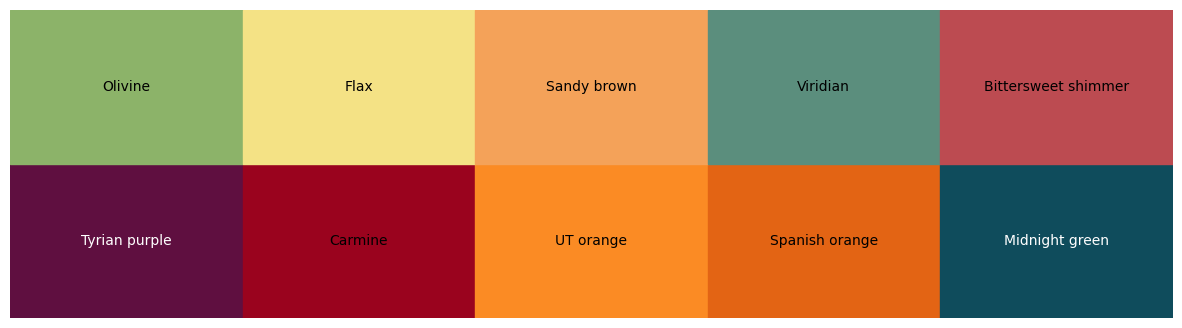

In [4]:
show_palette()

In [5]:
# load the inference dataset
idata = az.from_netcdf("./01_bspline_generated_example/idata.nc")
idata_lowK = az.from_netcdf("./01_bspline_generated_example/lowK/idata.nc")
idata_highK = az.from_netcdf("./01_bspline_generated_example/highK/idata.nc")

In [6]:
# Apply the Varimax + Signed Permutation algorithm for interpretation
Varimax_res_xr = bmlf.Varimax_RSP(idata)

Rotated sample 0
Rotated sample 500
Rotated sample 1000
Rotated sample 1500
Rotated sample 2000
Rotated sample 2500
Rotated sample 3000
Rotated sample 3500
Starting iteration number 0
	 Previous objective fun =	inf
	 New objective fun =		134892.289
Starting iteration number 1
	 Previous objective fun =	134892.289
	 New objective fun =		28934.319
Starting iteration number 2
	 Previous objective fun =	28934.319
	 New objective fun =		28664.334
Starting iteration number 3
	 Previous objective fun =	28664.334
	 New objective fun =		28648.400
Starting iteration number 4
	 Previous objective fun =	28648.400
	 New objective fun =		28642.781
Starting iteration number 5


## Check for outliers

In [7]:
get_expected_log_likelihood(idata, ['y_posterior'])

-16596.05275714432

In [8]:
get_expected_log_likelihood(idata, ['y_prior'])

-20813.046864956035

In [9]:
elpd = az.loo(idata, var_name='y_posterior')

In [10]:
elpd

Computed from 4000 posterior samples and 150 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -16666.93    84.77
p_loo      106.27        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      145   96.7%
 (0.5, 0.7]   (ok)          5    3.3%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [11]:
elpd_lowK = az.loo(idata_lowK, var_name='y_posterior')

In [12]:
elpd_lowK

Computed from 4000 posterior samples and 150 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -17166.56   100.29
p_loo       75.34        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      146   97.3%
 (0.5, 0.7]   (ok)          4    2.7%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

Still there are no "outliers" under model with lowK

In [13]:
elpd_highK = az.loo(idata_highK, var_name='y_posterior')

/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [14]:
elpd_highK

Computed from 4000 posterior samples and 150 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -16669.34    84.77
p_loo      121.61        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      141   94.0%
 (0.5, 0.7]   (ok)          8    5.3%
   (0.7, 1]   (bad)         1    0.7%
   (1, Inf)   (very bad)    0    0.0%

When looking at the model with high k we find an outlier!

In [15]:
elpd_highK_dict = dict( elpd_highK )

In [16]:
np.where( (elpd_highK_dict['pareto_k'] > 0.7).values )

(array([60]),)

We will plot sample 60 against idata_highK predictions later on the code

### Try other techniques for model comparison using WAIC

/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:805: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


array([[<Axes: title={'center': 'low k - true model'}, ylabel='ELPD difference'>,
        <Axes: >],
       [<Axes: title={'center': 'low k - high k'}, ylabel='ELPD difference'>,
        <Axes: title={'center': 'true model - high k'}>]], dtype=object)

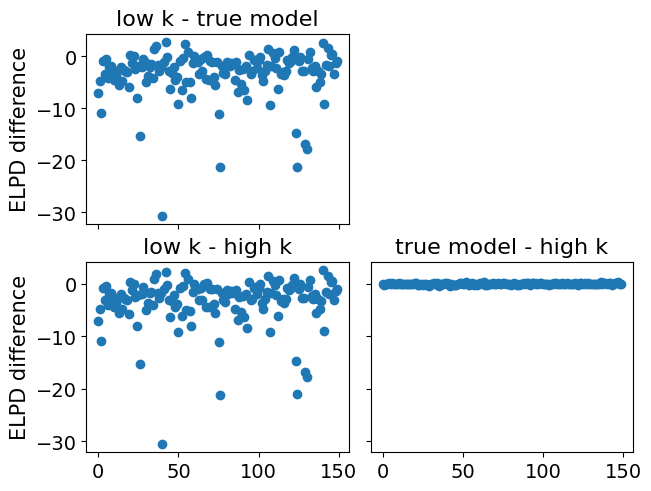

In [17]:
az.plot_elpd({
    'low k':idata_lowK,
    'true model':idata,
    'high k':idata_highK
}, var_name='y_posterior', ic='loo')

/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indicati

array([[<Axes: title={'center': 'low k - true model'}, ylabel='ELPD difference'>,
        <Axes: >],
       [<Axes: title={'center': 'low k - high k'}, ylabel='ELPD difference'>,
        <Axes: title={'center': 'true model - high k'}>]], dtype=object)

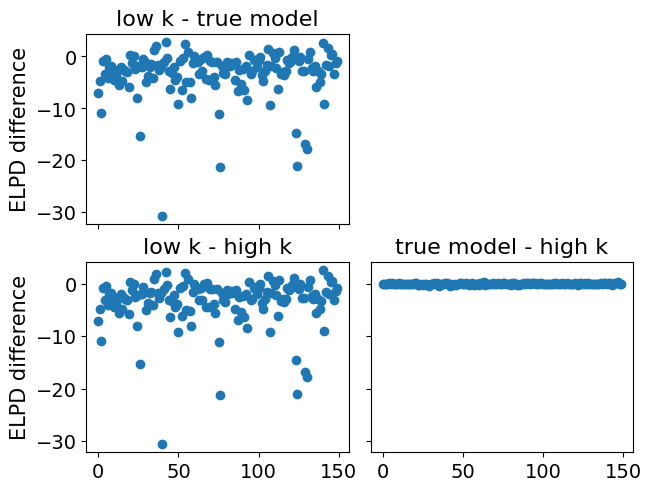

In [18]:
az.plot_elpd({
    'low k':idata_lowK,
    'true model':idata,
    'high k':idata_highK
}, var_name='y_posterior', ic='waic')

In [19]:
az_compare_res = \
az.compare({
    'low k':idata_lowK,
    'true model':idata,
    'high k':idata_highK    
}, var_name='y_posterior', ic='waic'
)

/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/stats/stats.py:1648: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indicati

In [20]:
az_compare_res

,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
true model,0,-16667.017538,106.352879,0.000000,1.000000e+00,84.785598,0.000000,True,log
high k,1,-16668.983385,121.253156,1.965847,3.210421e-10,84.771285,1.574852,True,log
low k,2,-17166.489204,75.268697,499.471667,0.000000e+00,100.307939,55.877704,True,log


/home/br1/PythonProjects/github/repo_bayesian_multitarget_latent_factors/examples/venv/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/compareplot.py:87: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  scale = comp_df["scale"][0]


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_waic (log)', ylabel='ranked models'>

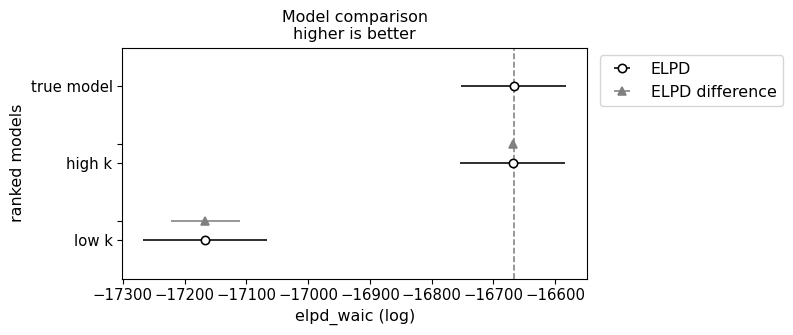

In [21]:
az.plot_compare(az_compare_res)

In [22]:
elpd_dict = dict( elpd )

In [23]:
from bayesian_multitarget_latent_factors.HMC_helper import show_dictionary_by_accordion

In [24]:
show_dictionary_by_accordion(elpd_dict)

Accordion(children=(Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output(), Output()),…

## Prediction on the Test Set

In [25]:
def plot_Y_wrapper_global(rng_seed, same_sample=True, sample_ul=0, sample_ur=0, sample_ll=0, sample_lr=0, 
                          target_ul=1, target_ur=2, target_ll=1, target_lr=2,
                          req_ul='predictive', req_ur='predictive', req_ll='predictive', req_lr='predictive',
                          conditional_ul=False, conditional_ur=False, conditional_ll=True, conditional_lr=True,
                          sharey='col'):
    
    plot_Y_wrapper(rng_seed=rng_seed, same_sample=same_sample, idata=idata, test_xr=test_xr, 
                   sample_ul=sample_ul, sample_ur=sample_ur, sample_ll=sample_ll, sample_lr=sample_lr, 
                   target_ul=target_ul, target_ur=target_ur, target_ll=target_ll, target_lr=target_lr,
                   req_ul=req_ul, req_ur=req_ur, req_ll=req_ll, req_lr=req_lr,
                   conditional_ul=conditional_ul, conditional_ur=conditional_ur, 
                   conditional_ll=conditional_ll, conditional_lr=conditional_lr,
                   sharey=sharey)

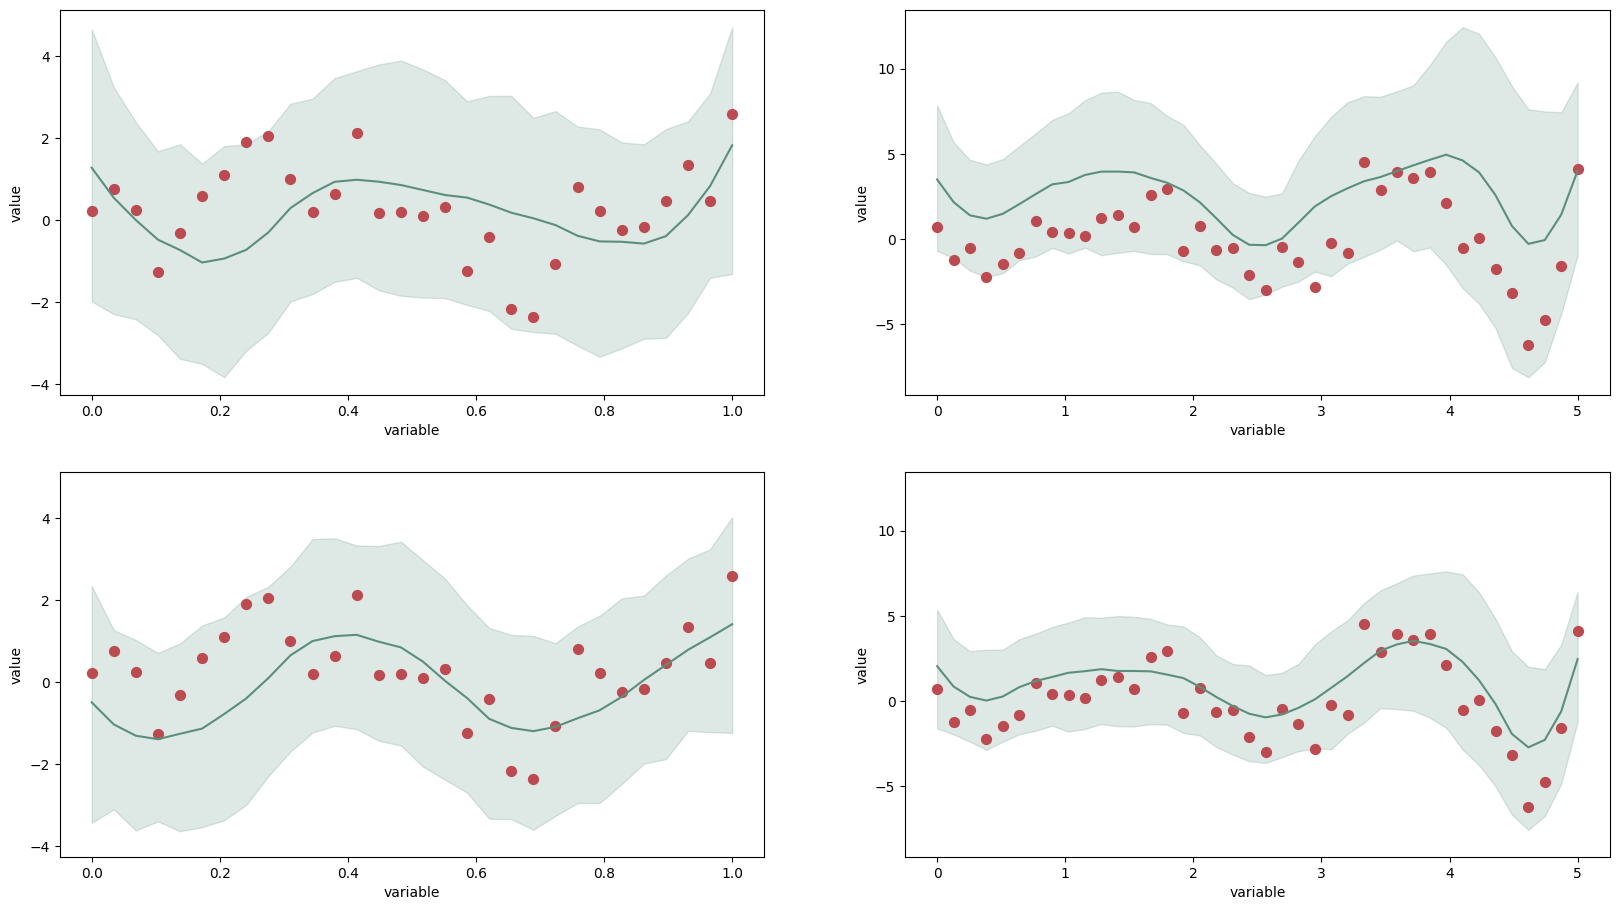

In [26]:
plot_Y_wrapper_global(123, sample_ul=19)

In [27]:
N = test_xr.sizes['X_test_dim_1']

interact(plot_Y_wrapper_global, rng_seed=widgets.IntSlider(min=1, max=500, step=1, value=123),
         sample_ul = range(N), sample_ur = range(N),
         sample_ll = range(N), sample_lr = range(N),
         target_ul = [1,2], target_ur = [1,2],
         target_ll = [1,2], target_lr = [1,2],
         req_ul = ['predictive','predictive idiosyncratic','predictive estimate'],
         req_ur = ['predictive','predictive idiosyncratic','predictive estimate'],
         req_ll = ['predictive','predictive idiosyncratic','predictive estimate'],
         req_lr = ['predictive','predictive idiosyncratic','predictive estimate'],
         sharey = ['none','row','col','all']
        )


interactive(children=(IntSlider(value=123, description='rng_seed', max=500, min=1), Checkbox(value=True, descr…

<function __main__.plot_Y_wrapper_global(rng_seed, same_sample=True, sample_ul=0, sample_ur=0, sample_ll=0, sample_lr=0, target_ul=1, target_ur=2, target_ll=1, target_lr=2, req_ul='predictive', req_ur='predictive', req_ll='predictive', req_lr='predictive', conditional_ul=False, conditional_ur=False, conditional_ll=True, conditional_lr=True, sharey='col')>

## Explore the relationship between one functional target and the other

In [28]:
def plot_heatmap_regression_global(pointwise = False, known_target = 1):
    plot_heatmap_regression(idata, pointwise, known_target)

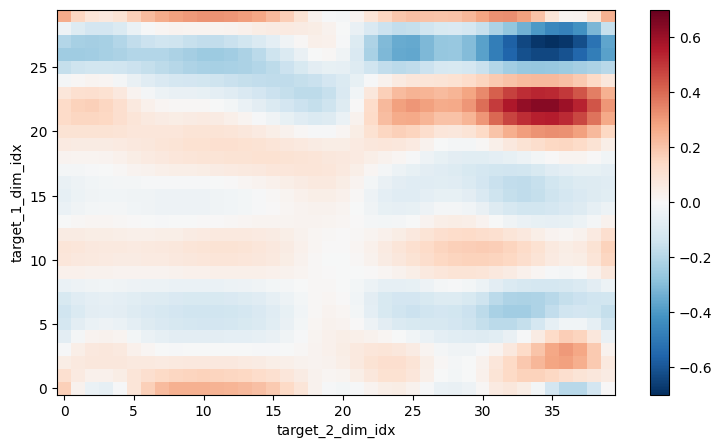

In [29]:
plot_heatmap_regression_global()

In [30]:
interact(plot_heatmap_regression_global, pointwise = False, known_target = [1,2])

interactive(children=(Checkbox(value=False, description='pointwise'), Dropdown(description='known_target', opt…

<function __main__.plot_heatmap_regression_global(pointwise=False, known_target=1)>

In [31]:
def plot_regression_by_PCA_global(pointwise = False, known_target = 1):
    plot_regression_by_PCA(idata, n_components = 3, pointwise = pointwise, known_target = known_target)

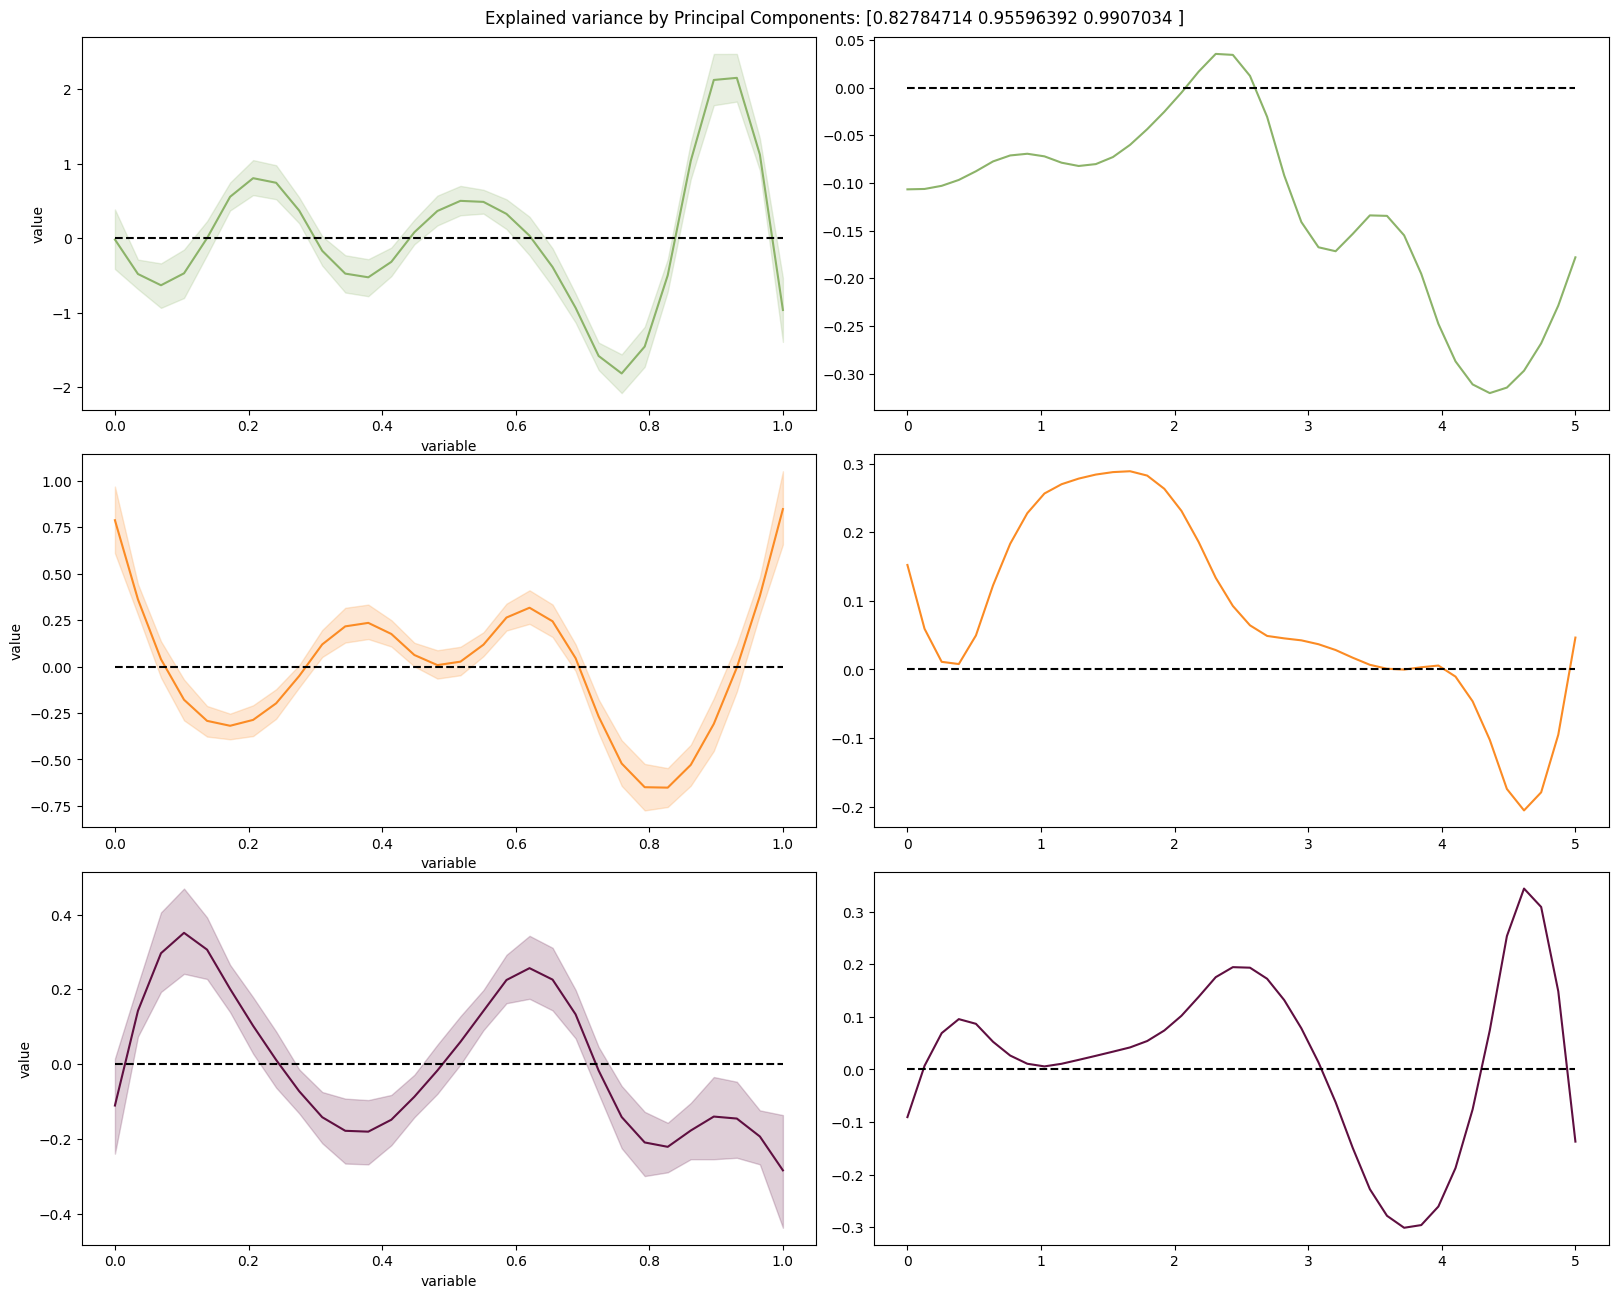

In [32]:
plot_regression_by_PCA_global()

In [33]:
interact(plot_regression_by_PCA_global, pointwise = False, known_target = [1,2])

interactive(children=(Checkbox(value=False, description='pointwise'), Dropdown(description='known_target', opt…

<function __main__.plot_regression_by_PCA_global(pointwise=False, known_target=1)>

## Estimated Latent Factors

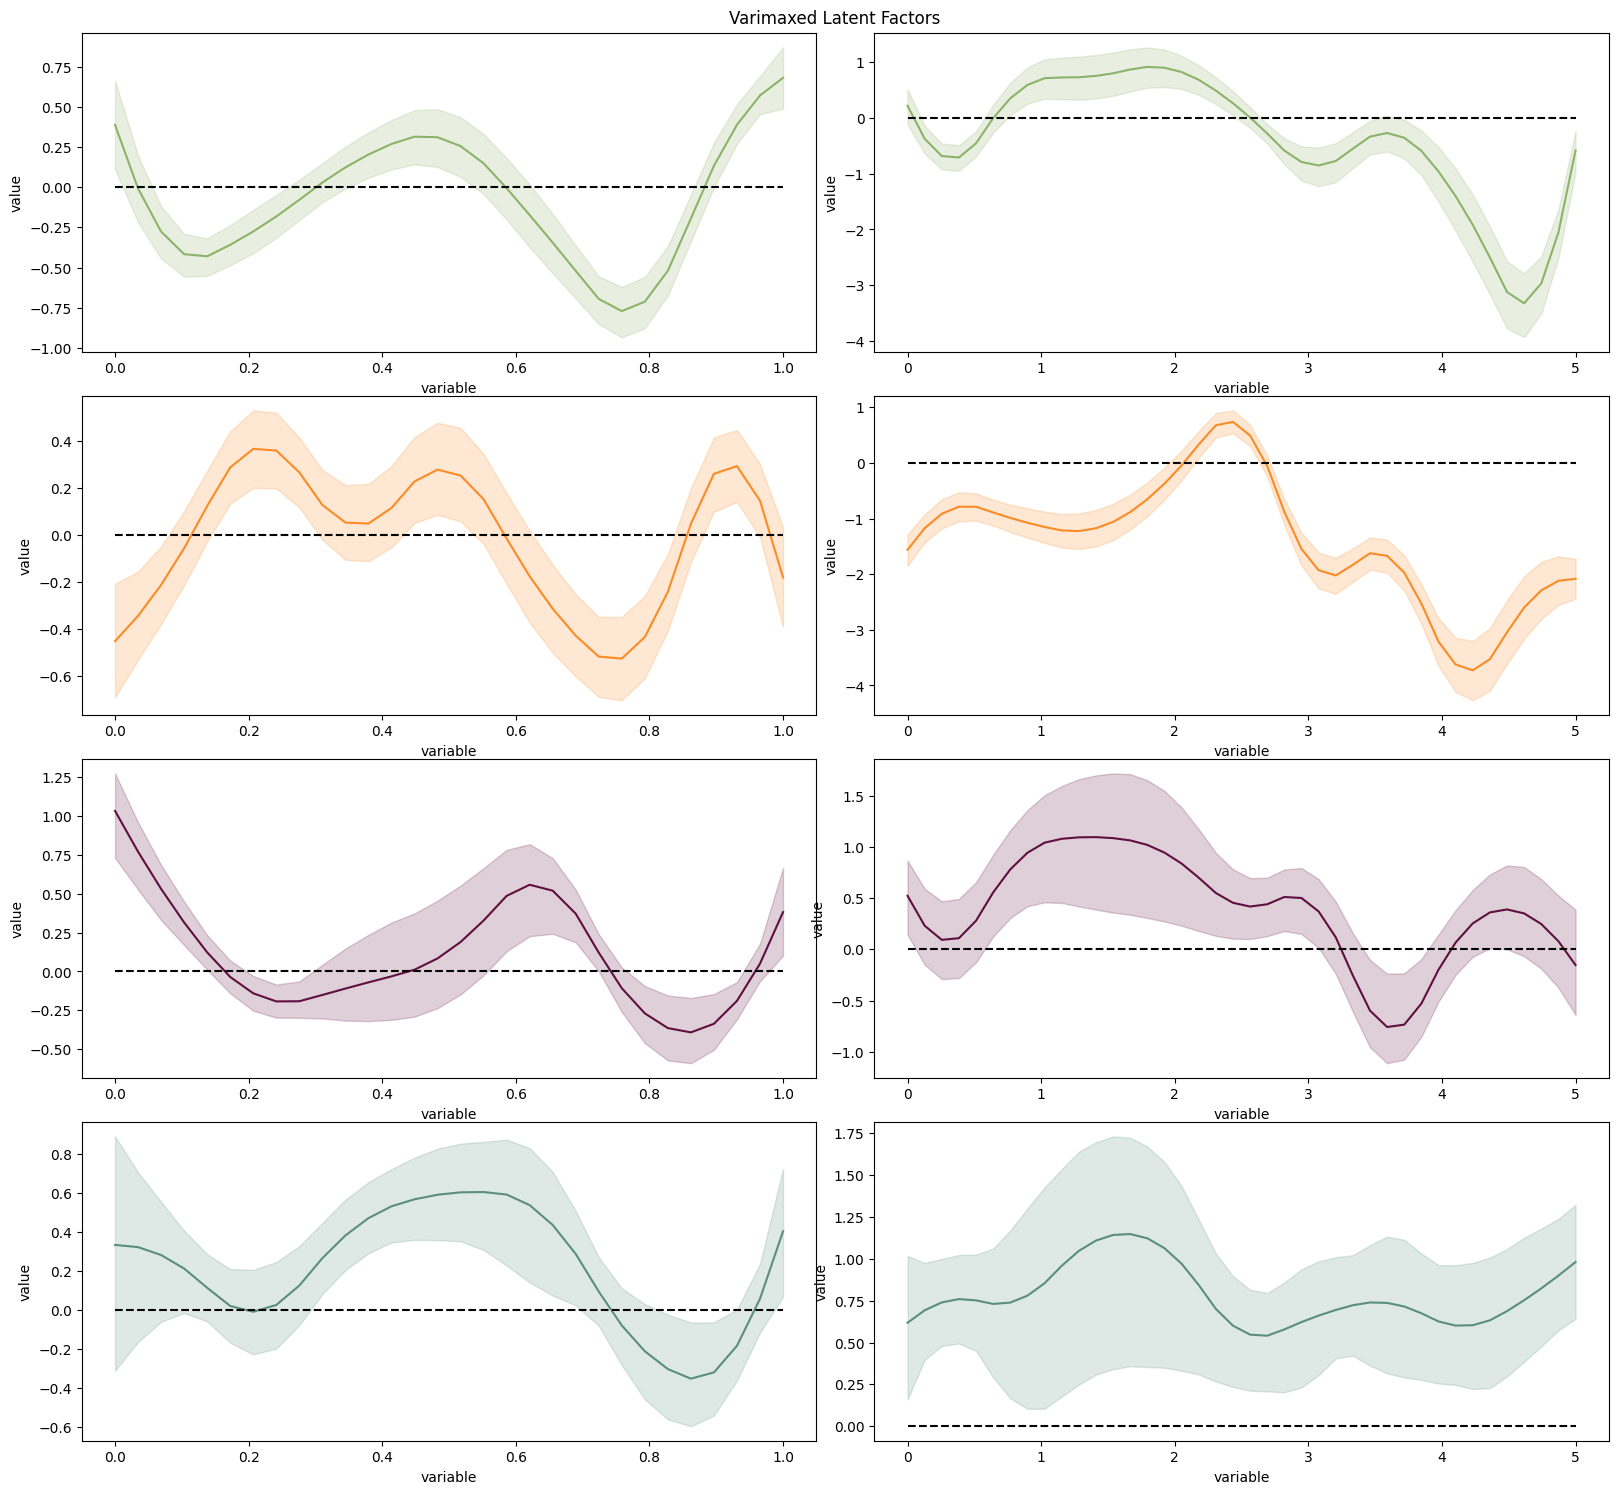

In [34]:
plot_varimaxed_latent_factors(idata, Varimax_res_xr)

## Estimated regression coefficients from Covariates to Latent Variables

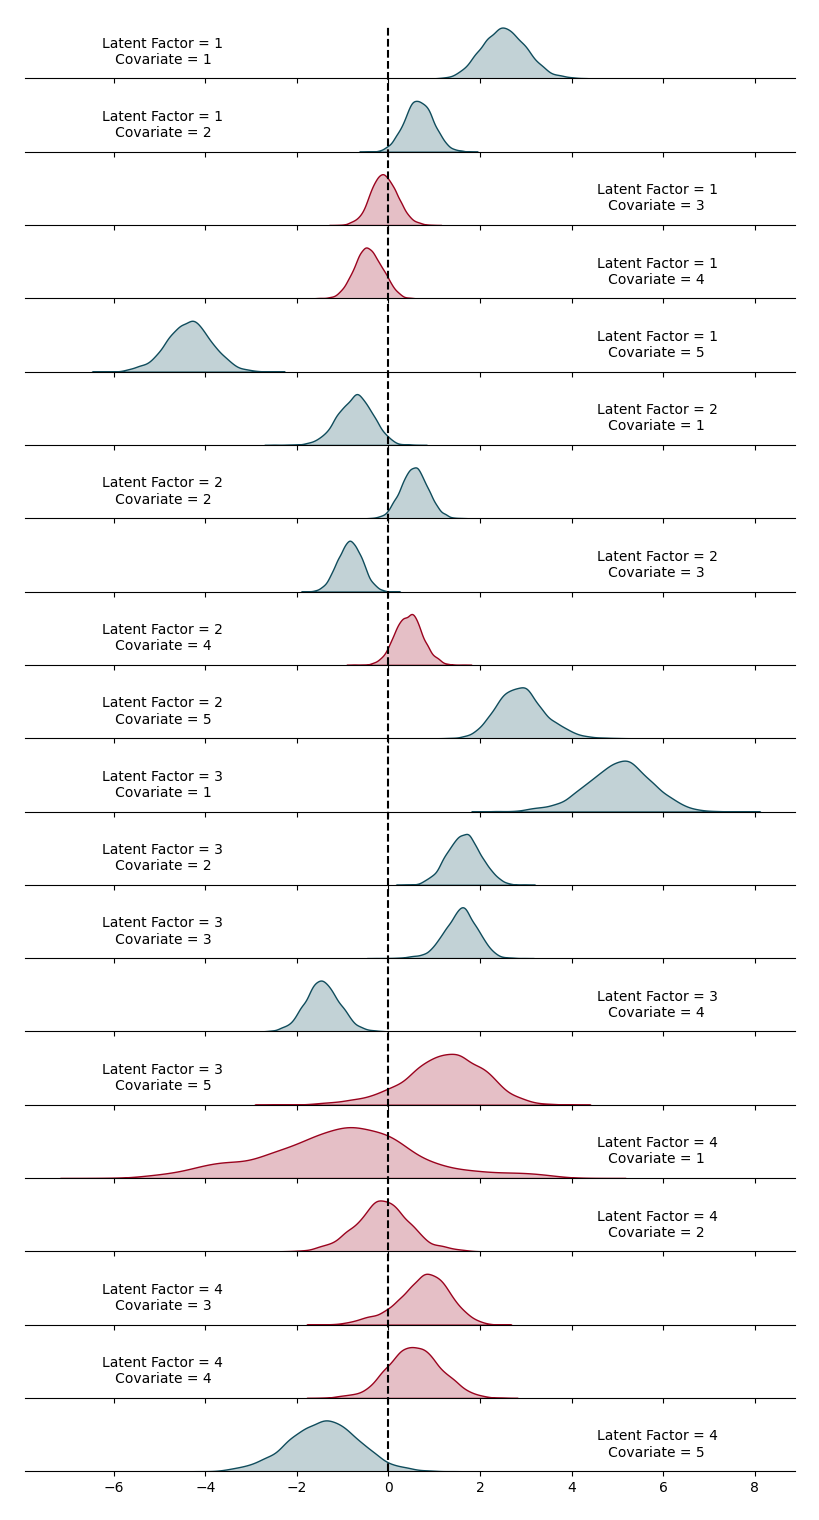

In [35]:
names_array = \
np.array([
    [('latent 1','regr 1'),('latent 2','regr 1'),('latent 3','regr 1'),('latent 4','regr 1')],
    [('latent 1','regr 2'),('latent 2','regr 2'),('latent 3','regr 2'),('latent 4','regr 2')],
    [('latent 1','regr 3'),('latent 2','regr 3'),('latent 3','regr 3'),('latent 4','regr 3')],
    [('latent 1','regr 4'),('latent 2','regr 4'),('latent 3','regr 4'),('latent 4','regr 4')],
    [('latent 1','regr 5'),('latent 2','regr 5'),('latent 3','regr 5'),('latent 4','regr 5')],
])

plot_regression_coefficients(Varimax_res_xr, grid=False)

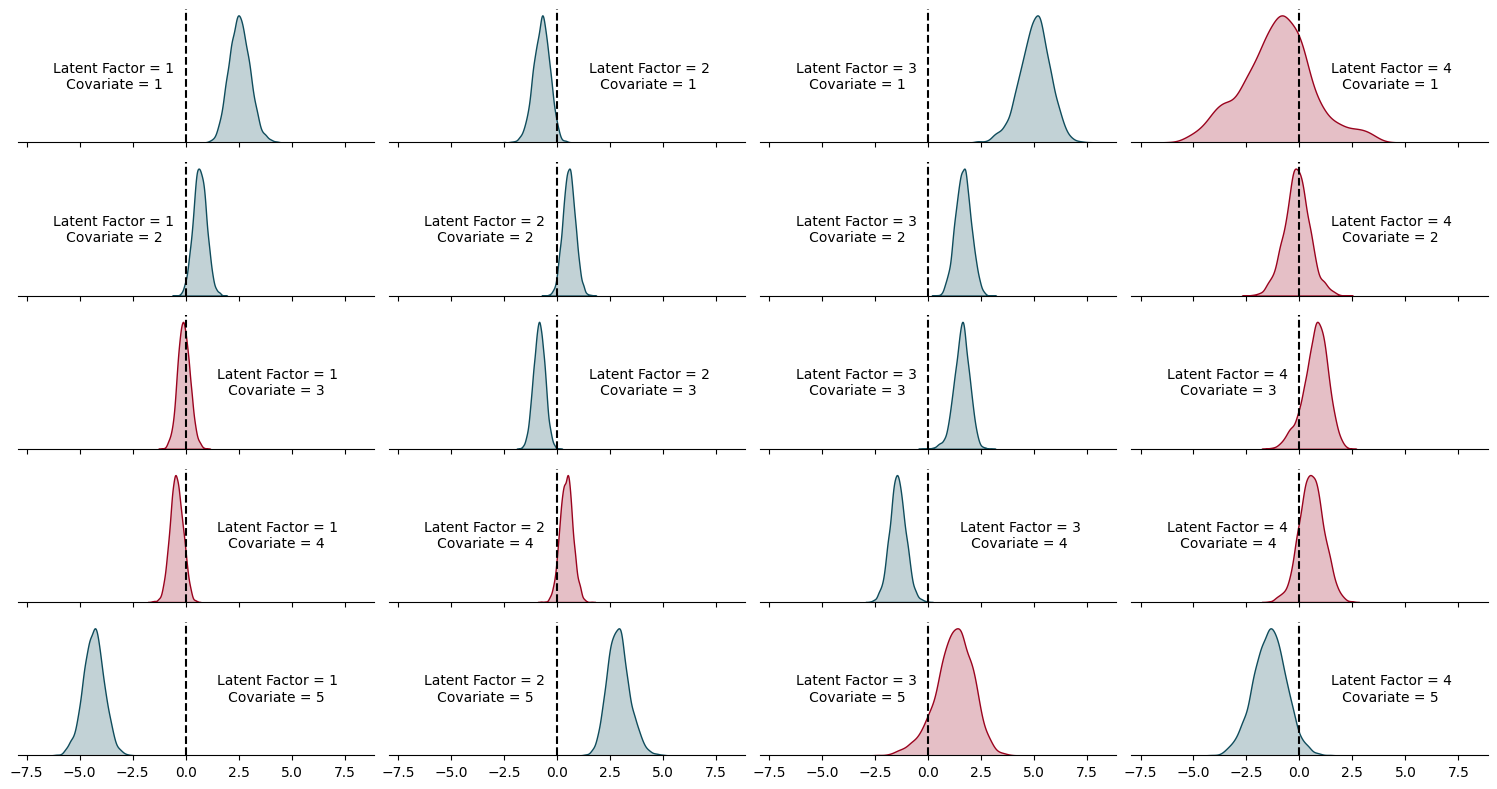

In [36]:
plot_regression_coefficients(Varimax_res_xr)

## Show the training set

In [37]:
from copy import deepcopy
train_xr = deepcopy( test_xr )

In [38]:
train_xr['X_test'] = idata.constant_data['X']
train_xr['y1'] = idata.observed_data['y1']
train_xr['y2'] = idata.observed_data['y2']

In [39]:
def plot_Y_wrapper_global(rng_seed, same_sample=True, sample_ul=0, sample_ur=0, sample_ll=0, sample_lr=0, 
                          target_ul=1, target_ur=2, target_ll=1, target_lr=2,
                          req_ul='predictive', req_ur='predictive', req_ll='predictive', req_lr='predictive',
                          conditional_ul=False, conditional_ur=False, conditional_ll=True, conditional_lr=True,
                          sharey='col'):
    plot_Y_wrapper(rng_seed=rng_seed, same_sample=same_sample, idata=idata, test_xr=train_xr, 
                   sample_ul=sample_ul, sample_ur=sample_ur, sample_ll=sample_ll, sample_lr=sample_lr, 
                   target_ul=target_ul, target_ur=target_ur, target_ll=target_ll, target_lr=target_lr,
                   req_ul=req_ul, req_ur=req_ur, req_ll=req_ll, req_lr=req_lr,
                   conditional_ul=conditional_ul, conditional_ur=conditional_ur, 
                   conditional_ll=conditional_ll, conditional_lr=conditional_lr,
                   sharey=sharey)


In [40]:
N = train_xr.sizes['X_dim_1']

interact(plot_Y_wrapper_global, rng_seed=widgets.IntSlider(min=1, max=500, step=1, value=123),
         sample_ul = range(N), sample_ur = range(N),
         sample_ll = range(N), sample_lr = range(N),
         target_ul = [1,2], target_ur = [1,2],
         target_ll = [1,2], target_lr = [1,2],
         req_ul = ['predictive','predictive idiosyncratic','predictive estimate'],
         req_ur = ['predictive','predictive idiosyncratic','predictive estimate'],
         req_ll = ['predictive','predictive idiosyncratic','predictive estimate'],
         req_lr = ['predictive','predictive idiosyncratic','predictive estimate'],
         sharey = ['none','row','col','all']
        )


interactive(children=(IntSlider(value=123, description='rng_seed', max=500, min=1), Checkbox(value=True, descr…

<function __main__.plot_Y_wrapper_global(rng_seed, same_sample=True, sample_ul=0, sample_ur=0, sample_ll=0, sample_lr=0, target_ul=1, target_ur=2, target_ll=1, target_lr=2, req_ul='predictive', req_ur='predictive', req_ll='predictive', req_lr='predictive', conditional_ul=False, conditional_ur=False, conditional_ll=True, conditional_lr=True, sharey='col')>

## Outlier for high_k in the training set

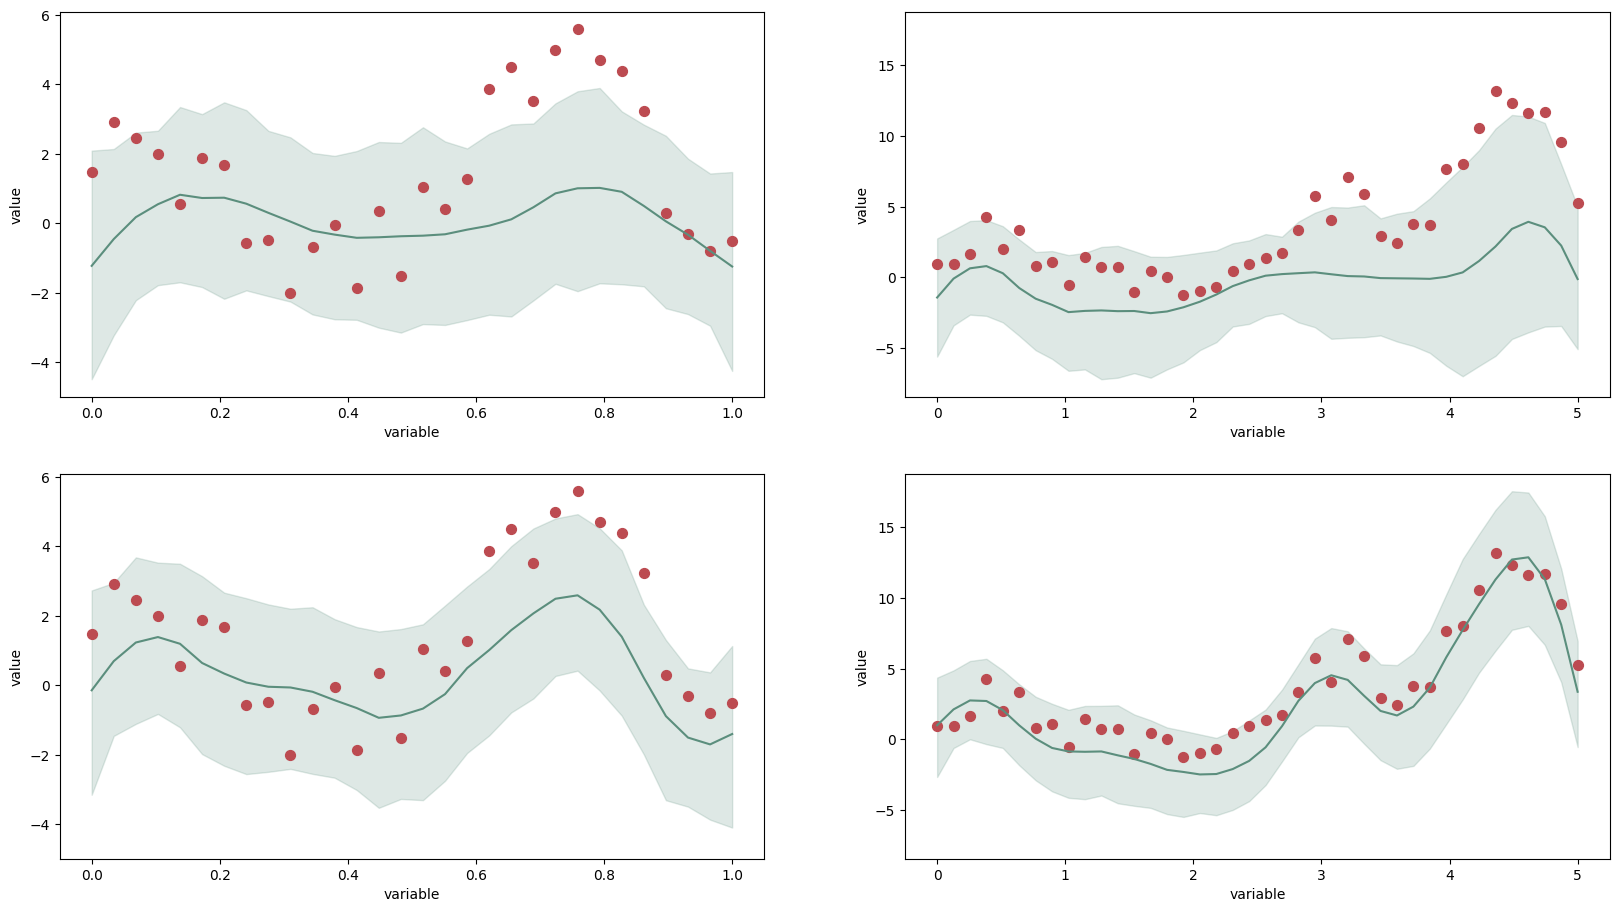

In [41]:
plot_Y_wrapper(123, idata_highK, train_xr)

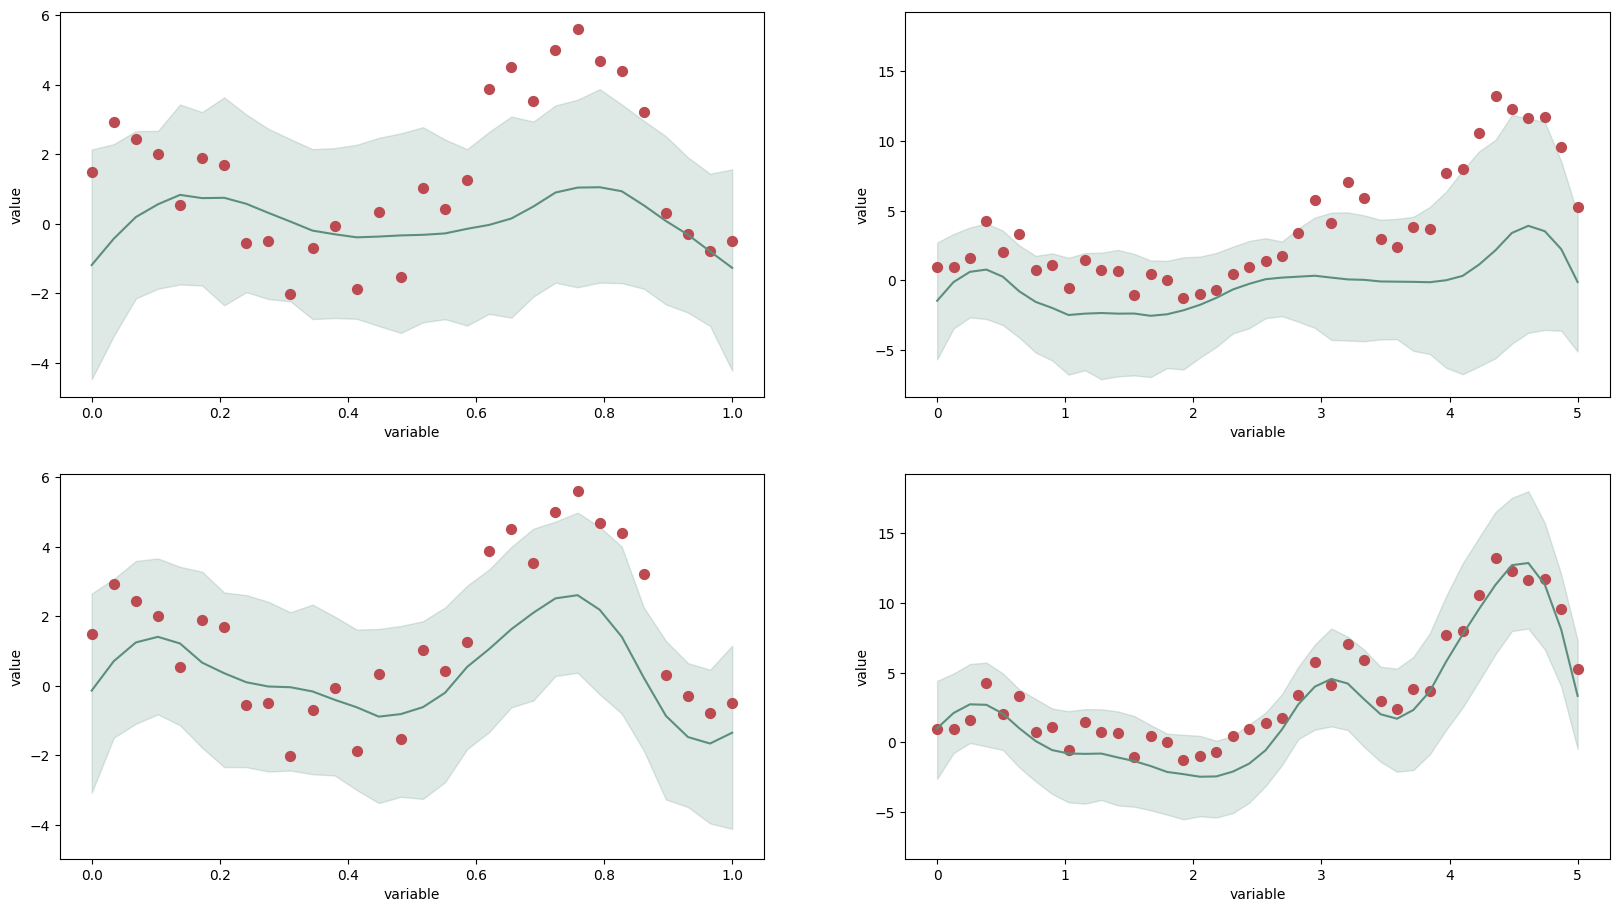

In [42]:
plot_Y_wrapper(123, idata, train_xr)

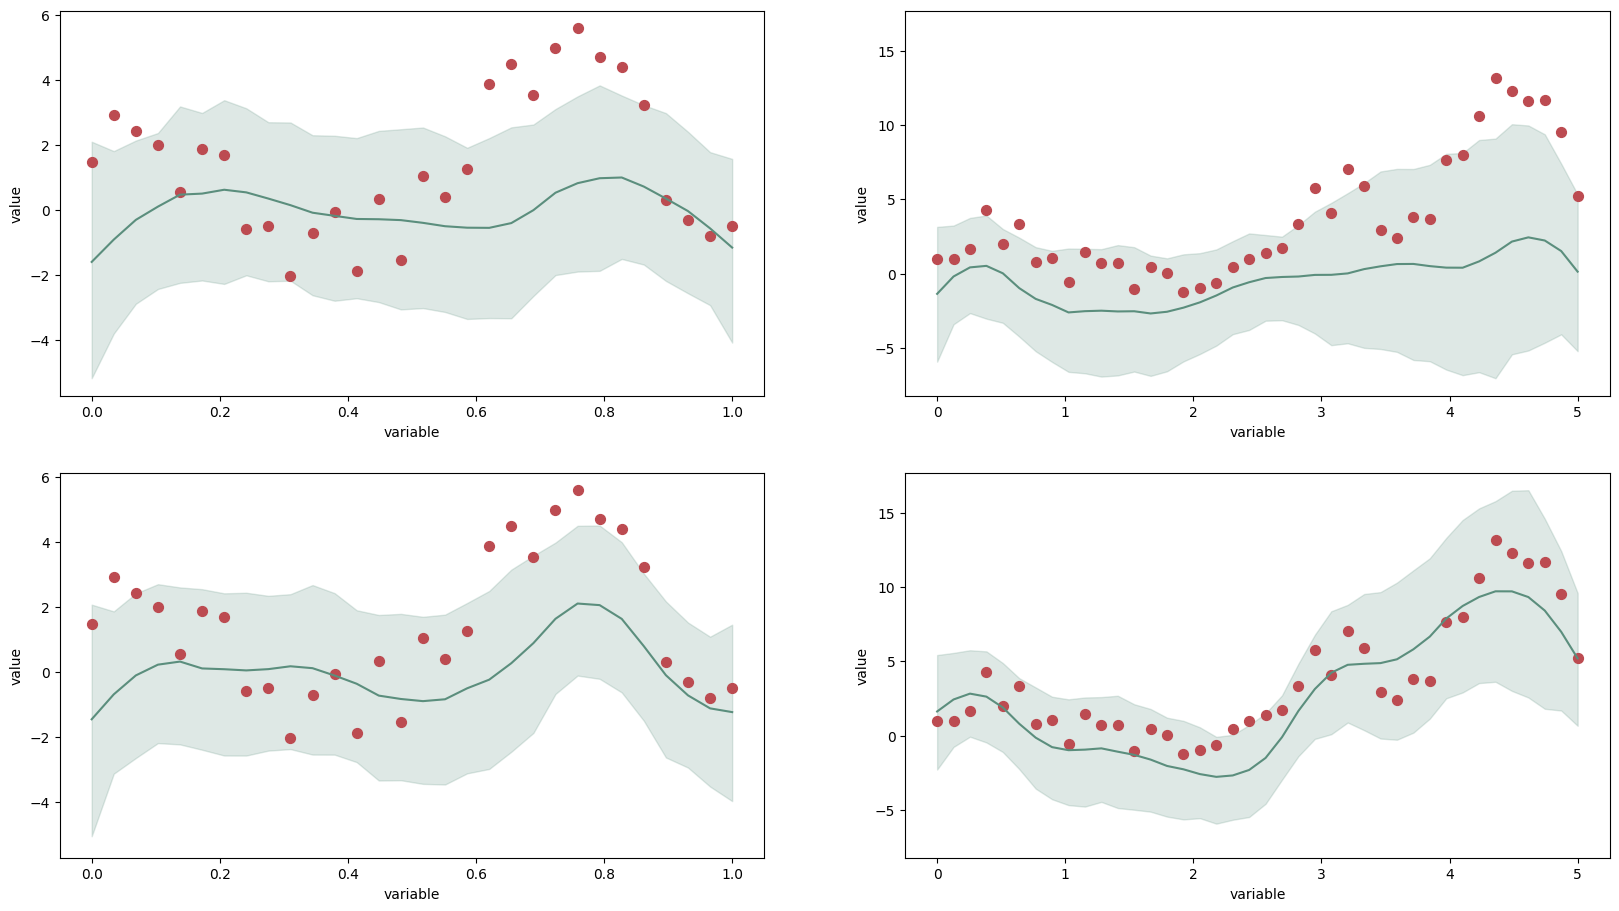

In [43]:
plot_Y_wrapper(123, idata_lowK, train_xr)

I'm not seeing anything overwhelmingly awful, but a deeper investigation is needed to understand

## Estimated Latent Factors for LowK

In [44]:
Varimax_lowK_res_xr = bmlf.Varimax_RSP(idata_lowK)

Rotated sample 0
Rotated sample 500
Rotated sample 1000
Rotated sample 1500
Rotated sample 2000
Rotated sample 2500
Rotated sample 3000
Rotated sample 3500
Starting iteration number 0
	 Previous objective fun =	inf
	 New objective fun =		48802.374
Starting iteration number 1
	 Previous objective fun =	48802.374
	 New objective fun =		20771.497
Starting iteration number 2


### Latent Factors plot

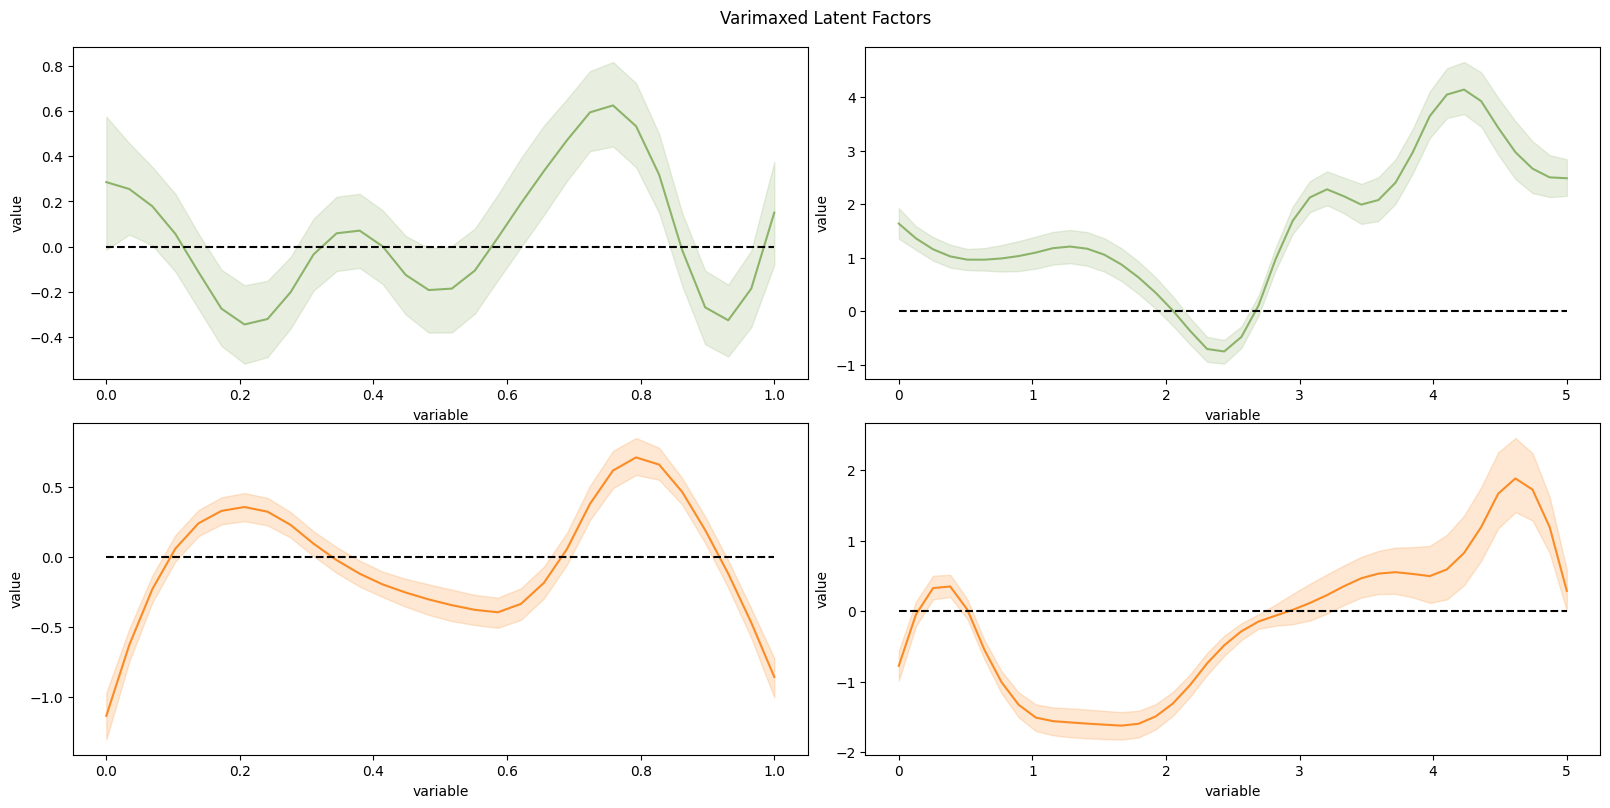

In [45]:
plot_varimaxed_latent_factors(idata_lowK, Varimax_lowK_res_xr, figheight=8)

Observation! The same factors where estimated in the low K case, but the order is inverted

### Estimated regression coefficients from Covariates to Latent Variables

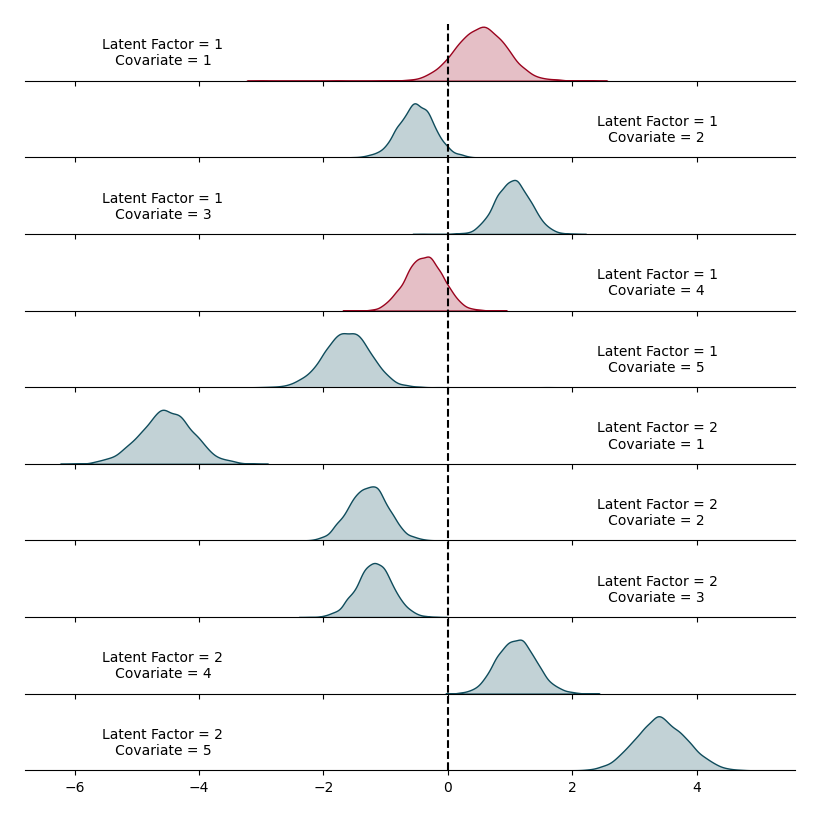

In [46]:
plot_regression_coefficients(Varimax_lowK_res_xr, grid=False, major_dim=8)

## Varimax for Overparametrized model

In [47]:
Varimax_highK_res_xr = bmlf.Varimax_RSP(idata_highK)

Rotated sample 0
Rotated sample 500
Rotated sample 1000
Rotated sample 1500
Rotated sample 2000
Rotated sample 2500
Rotated sample 3000
Rotated sample 3500
Starting iteration number 0
	 Previous objective fun =	inf
	 New objective fun =		183201.291
Starting iteration number 1
	 Previous objective fun =	183201.291
	 New objective fun =		74596.748
Starting iteration number 2
	 Previous objective fun =	74596.748
	 New objective fun =		38084.641
Starting iteration number 3
	 Previous objective fun =	38084.641
	 New objective fun =		37766.330
Starting iteration number 4
	 Previous objective fun =	37766.330
	 New objective fun =		37700.063
Starting iteration number 5
	 Previous objective fun =	37700.063
	 New objective fun =		37688.401
Starting iteration number 6
	 Previous objective fun =	37688.401
	 New objective fun =		37684.111
Starting iteration number 7


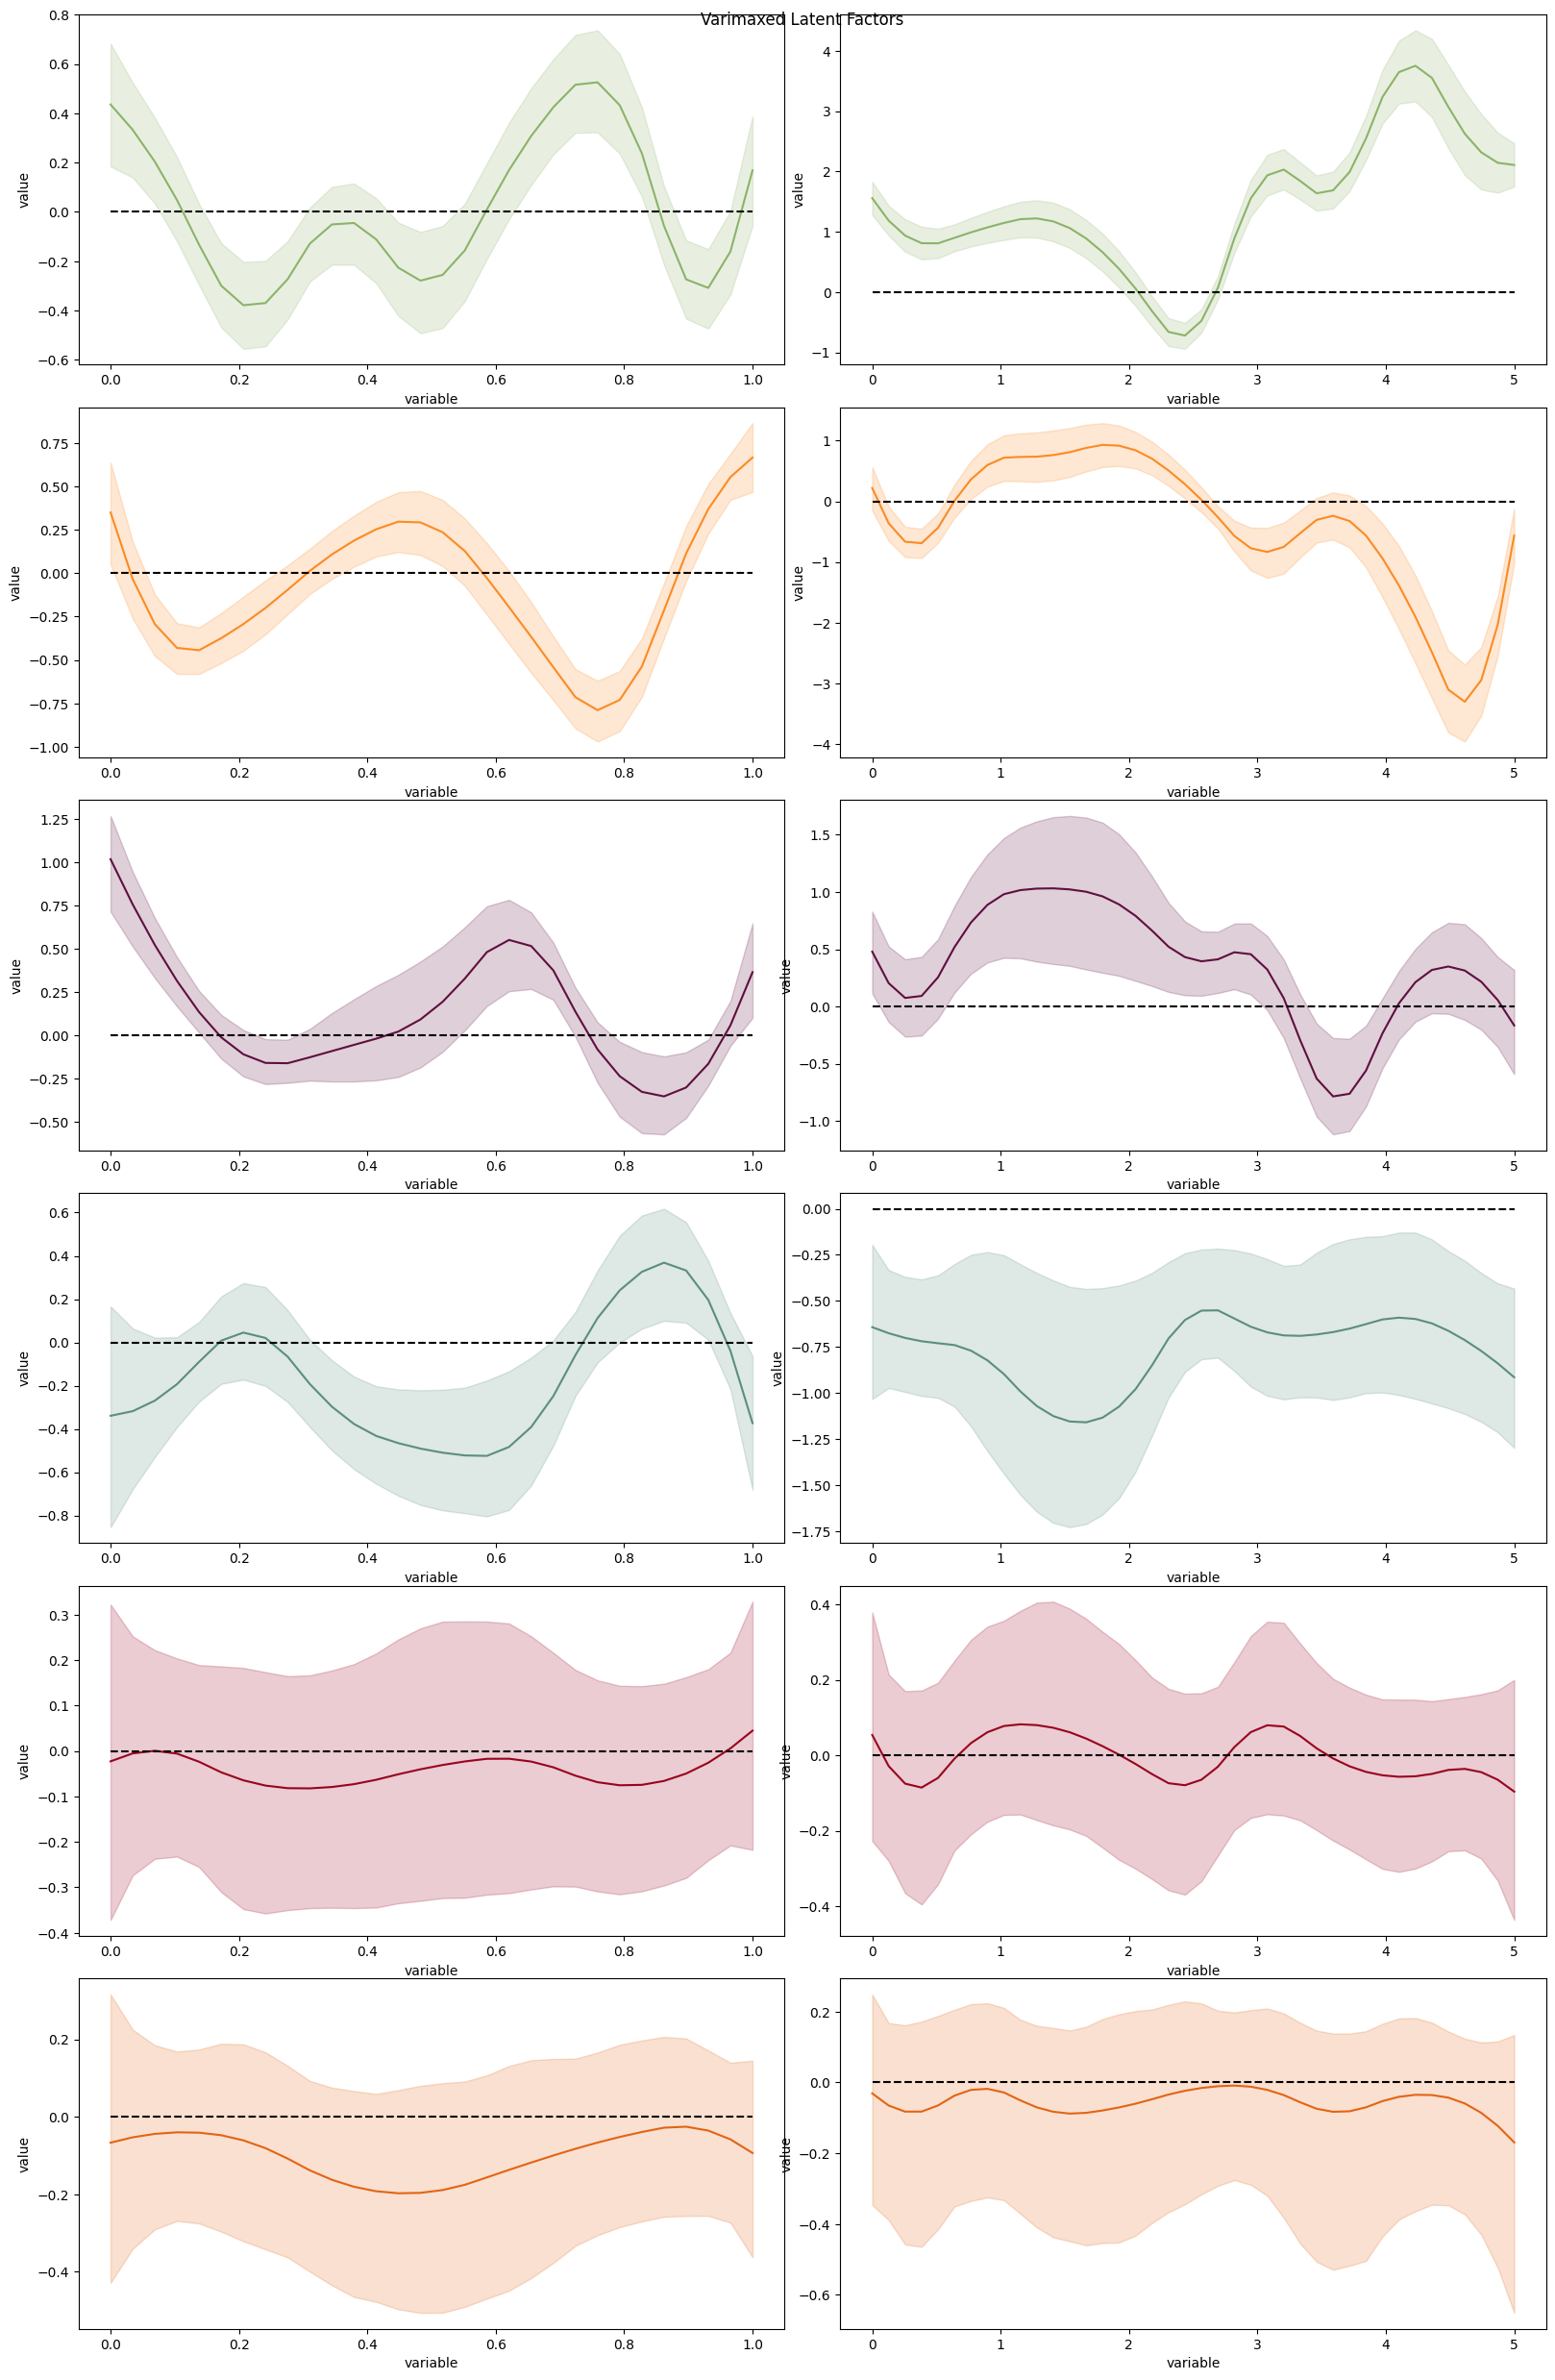

In [48]:
plot_varimaxed_latent_factors(idata_highK, Varimax_highK_res_xr, figheight=25)

To the unuseful factors we correctly achieve an identically equal to zero posterior

This explain why posterior predictive checks don't punish high K